# import statements

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from functions import *


# Load Training Data

In [2]:
cars = glob.glob('dataset/vehicles/**/*.png')
notcars = glob.glob('dataset/non-vehicles/**/*.png')
print("car images=",len(cars))
print("non-car images=",len(notcars))

car images= 8792
non-car images= 8968


# Visualize Some of the Data

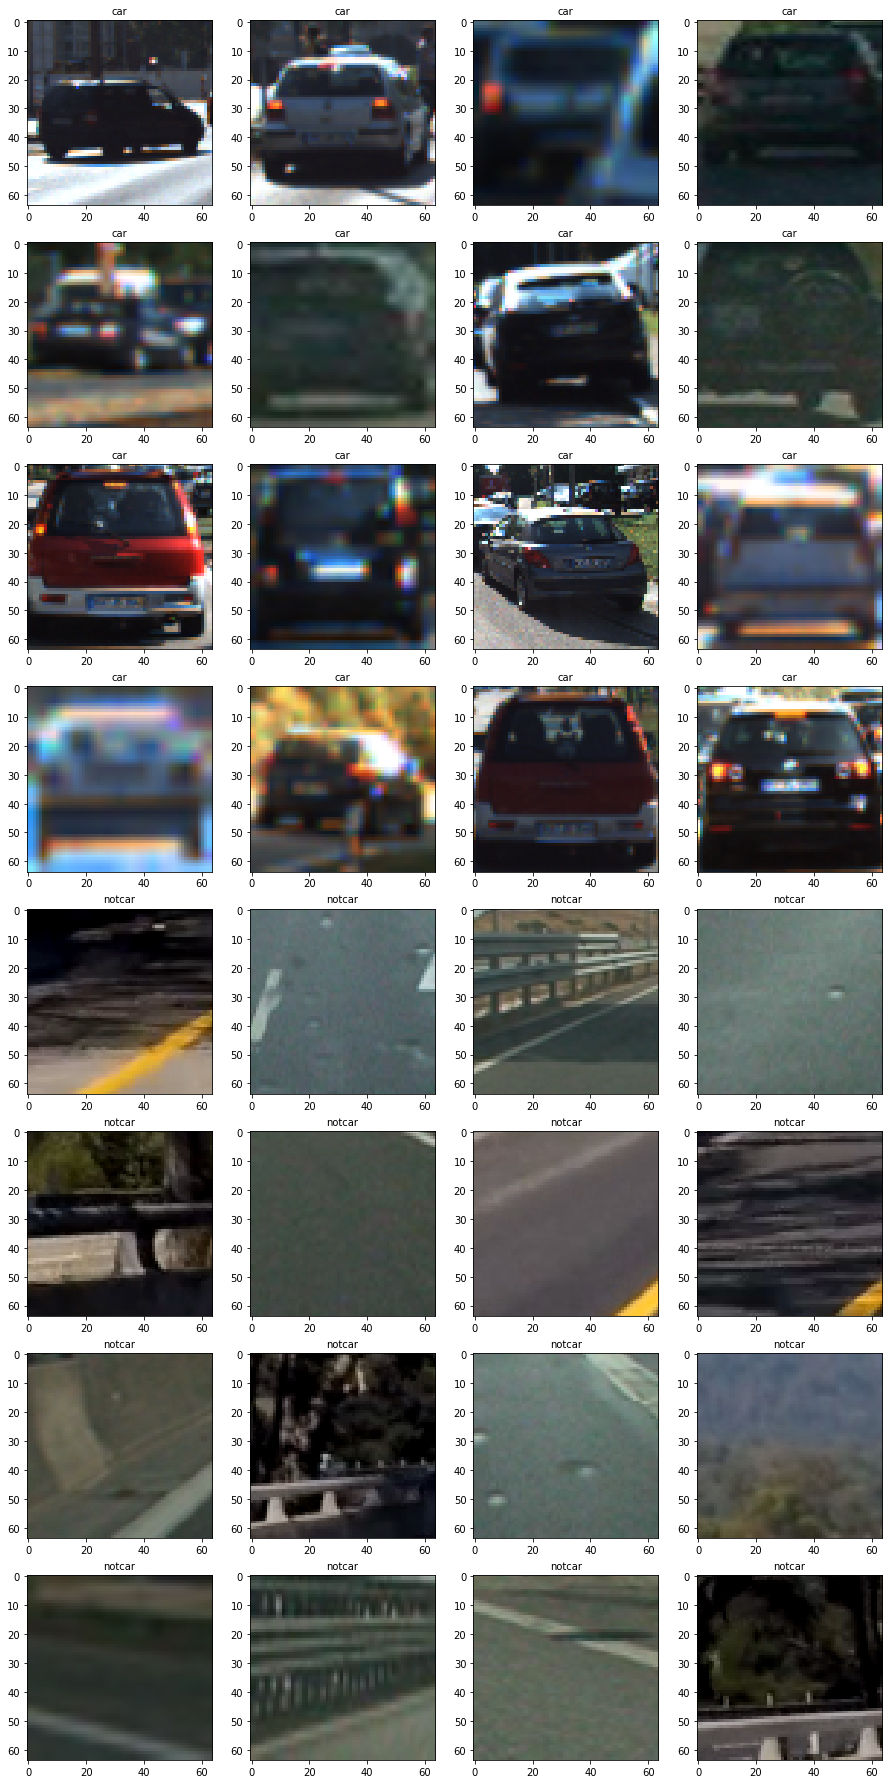

In [3]:
fig, axs = plt.subplots(8,4, figsize=(16, 32))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and take 16 random images
for i in range(16):
    img_id = np.random.randint(0,len(cars))
    img = cv2.imread(cars[img_id])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)

for i in range(16,32):
    img_id = np.random.randint(0,len(notcars))
    img = cv2.imread(notcars[img_id])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].set_title('notcar', fontsize=10)
    axs[i].imshow(img)

# Visualize HOG features

Text(0.5,1,'NotCar HOG')

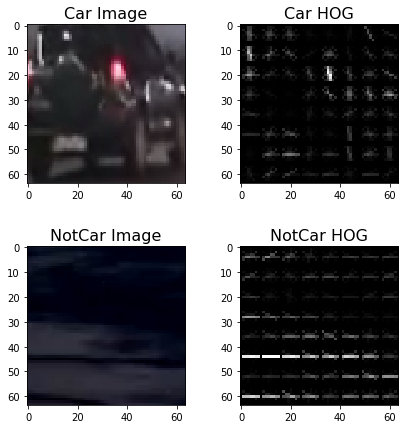

In [4]:
img_id = np.random.randint(0,len(cars))
car_img = mpimg.imread(cars[img_id])
car_features, car_dst = get_hog_features(car_img, 9, 8, 8, vis=True, feature_vec=True)

notcar_img = mpimg.imread(notcars[img_id])
notcar_features, notcar_dst = get_hog_features(notcar_img, 9, 8, 8, vis=True, feature_vec=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('NotCar Image', fontsize=16)
ax4.imshow(notcar_dst, cmap='gray')
ax4.set_title('NotCar HOG', fontsize=16)

# Extract features form car and notcar images

In [5]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 4 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
##DWEEP: y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Features generated!")

Features generated!


# Construct training and testing dataset

In [6]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), -1.0*np.ones(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

X_scaler = None
if hist_feat or spatial_feat:
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 12 orientations 16 pixels per cell and 4 cells per block
Feature vector length: 577


# Train linear SVM 

35.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9865


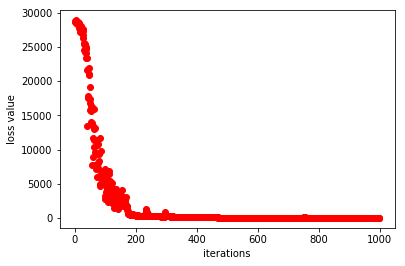

In [7]:
# Use a linear SVC 
from linearSVM import PegasosSVM
svc = PegasosSVM()
# Check the training time for the SVC
t=time.time()
w_l,train_obj = svc.fit(X_train, y_train, lamb=0.0001, k=100, max_iterations=1000)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test, w_l), 4))
plt.figure(1)
plt.plot(range(len(train_obj)), train_obj, 'ro')
plt.xlabel('iterations')
plt.ylabel('loss value')
plt.show()

# Test find_cars() and draw_boxes()

In [ ]:
test_img = mpimg.imread('./test_images/test1.jpg')

predictions = find_cars(test_img, 400, 656, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
test_img_with_preds = draw_boxes(test_img, predictions)

plt.figure(figsize=(16,16))
plt.imshow(test_img_with_preds)

# Sliding Window Search with different scales

In [ ]:
predictions = []

ystart = 400
ystop = 660

for scale in np.arange(1.0,3.5,0.5):
    
    curr_pred = find_cars(test_img, ystart, ystop, scale, svc, 
                             X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
    predictions += curr_pred 
    
    print("scale:",scale,"Total predictions:",len(curr_pred))
    test_img_with_preds = draw_boxes(test_img, curr_pred, color='random', thick=2)
    plt.figure(figsize=(16,16))
    plt.title('scale='+str(scale), fontsize=16)
    plt.imshow(test_img_with_preds)

test_img_with_preds = draw_boxes(test_img, predictions, color='random', thick=2)
plt.figure(figsize=(16,16))
plt.title('combined sliding window search result',fontsize=16)
plt.imshow(test_img_with_preds)   
print('Total Number of boxes: ', len(predictions))

Reason to choose scale values:
#<1.0 value for scale gives very small boxes, objects that we are trying to identify are not that small. Also, a lot of small boxes give a lot of false positives
#>3.0 value for scale gives very big boxes, objects that we are trying to identify are not that big.

# Test Heatmap related methods

In [ ]:
# Read in image similar to one shown above 
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,predictions)
plt.figure(figsize=(10,10))
plt.imshow(heat, cmap='hot')
plt.title('add_heat()')


# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
plt.figure(figsize=(10,10))
plt.imshow(heatmap, cmap='hot')
plt.title('apply_threshold()')

# Find final boxes from heatmap using label function
labels = label(heatmap)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.title('label()')
print('number of cars found:',labels[1])

#draw final bounding boxes on a copy of the original image
draw_img, final_predictions = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)
plt.title('final output')

# End-to-End pipeline

In [ ]:
def process_one_image(test_img):
    #test_img must be a numpy array
    predictions = []
    ##DWEEP: Need to tune these two values to get better results
    ystart = 400
    ystop = 660

    for scale in np.arange(1.0,3.5,0.5):
    
        curr_pred = find_cars(test_img, ystart, ystop, scale, svc, 
                              X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space)
        predictions += curr_pred
        
    
    heat = np.zeros_like(test_img[:,:,0])
    # Add heat to each box in box list
    heat = add_heat(heat,predictions)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    print('number of cars found:',labels[1])
    #draw final bounding boxes on a copy of the original image
    draw_img, final_predictions = draw_labeled_bboxes(np.copy(test_img), labels)
    
    return draw_img

# Test the pipleline on test images

In [ ]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_one_image(mpimg.imread(im)))
    axs[i].axis('off')

# Test the pipleline on video 1

In [ ]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_one_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)
clip_test.reader.close()
clip_test.audio.reader.close_proc()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

# Run Pipeline on video 2

In [ ]:
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_one_image)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)
clip_proj.reader.close()
clip_proj.audio.reader.close_proc()

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_out_file))